In [2]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation

# import kmos_tools as KT
import reionizer
import pandas as pd
import scipy.interpolate
import os
import scipy
from scipy import interpolate, integrate
from scipy.integrate import ode

# import corner
from astropy.cosmology import Planck15
import astropy.units as u
import astropy.constants as const

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

# Colors
from palettable.colorbrewer.qualitative import Dark2_7
from palettable.colorbrewer.qualitative import Set1_7
from palettable.tableau import Tableau_10
col = Dark2_7.hex_colors
col2 = Tableau_10.hex_colors
col = Set1_7.hex_colors

from palettable.cubehelix import cubehelix3_16
cubehelix = cubehelix3_16.hex_colors

import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)

import sys
sys.path.append('../')
import bubbles

In [3]:
%load_ext autoreload
%autoreload 2

# Linking Lya velocity offset to bubble size

If only Lya with a given velocity offset can escape IGM with high transmission, can we infer minimum bubble size?

# Lya cross-section

This looks fine

1210.81064713464 Angstrom 1221.2340259037169 Angstrom


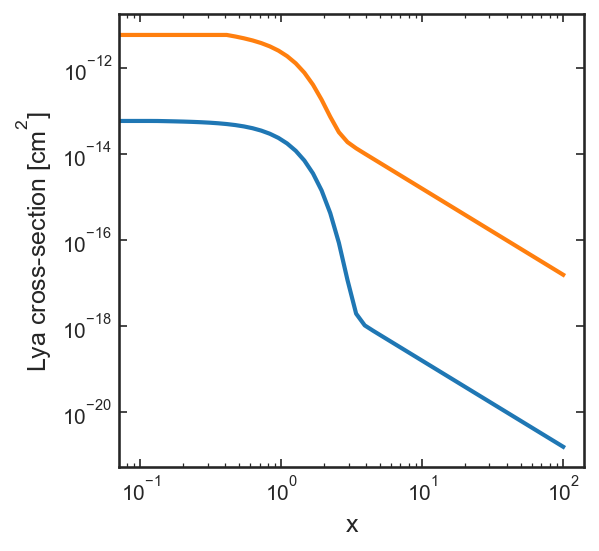

In [4]:
xtab_neg = -np.logspace(-1,2)
xtab_pos = np.logspace(-1,2)
xtab     = np.sort(np.concatenate((xtab_neg, xtab_pos)))

plt.loglog(xtab, bubbles.lya_cross_section.Lya_crosssec(wave=bubbles.lya_cross_section.Lya_x_to_wave(xtab, T=1e4*u.K), T=1e4*u.K), label='$T = 10^4$ K')
plt.loglog(xtab, bubbles.lya_cross_section.Lya_crosssec(wave=bubbles.lya_cross_section.Lya_x_to_wave(xtab, T=1*u.K), T=1.*u.K), label='$T = 1^4$ K')

plt.xlabel('x')
plt.ylabel('Lya cross-section [cm$^2$]')

print(bubbles.lya_cross_section.Lya_x_to_wave(xtab, T=1e4*u.K).min(), bubbles.lya_cross_section.Lya_x_to_wave(xtab, T=1e4*u.K).max())

# Estimate neutral fraction in a bubble

Use [Cen & Haiman (2000)](https://ui.adsabs.harvard.edu/abs/2000ApJ...542L..75C/abstract), [Haiman (2004)](https://ui.adsabs.harvard.edu/abs/2002ApJ...576L...1H/abstract), [Mesinger, Haiman & Cen (2004)](https://ui.adsabs.harvard.edu/abs/2004ApJ...613...23M/abstract)

## Cen & Haiman

In [5]:
def R_bubble_CenHaiman2000(z_s, Ndot_ion=2.e57/u.s, t_source=1e7*u.year):
    R_bubble = (0.75*Ndot_ion*t_source/np.pi/bubbles.n_H(z_s))**(1./3.)
    return (R_bubble).to(u.Mpc)

def x_HI_bubble(z, z_s=7., C_HII=3., Ndot_ion=1.e57/u.s):
    """
    Neutral fraction in a HII region as a function of distance from it
    
    TODO: assumes quasar ionizing spectrum
    """
    r = bubbles.comoving_distance_from_source_Mpc(z, z_s)
    
    # Neutral fraction
    xHI = 1.e-6 * C_HII * (r/1/u.Mpc)**2. * (Ndot_ion/1.e57*u.s)**-1. * ((1.+z)/8.)**3.
    
    xHI[xHI > 1.] = 1.
    
    return xHI

## Stromgren sphere

In [6]:
eV_tab = np.logspace(np.log10(13.6), 4)*u.eV
nu = (eV_tab/const.h).to(u.Hz)
sigma_ion = 6.304e-18*u.cm**2. * (nu / bubbles.nu_H)**-3.
    
def R_bubble_Stromgren(z_s, Ndot_ion=2.e57/u.s, C=3., alpha_B=2.59e-13*u.cm**3./u.s):
    """
    Stromgren sphere solution (ionization equilibrium)
    """
    return ((3.*Ndot_ion/4./np.pi/alpha_B/bubbles.n_H(z_s)**2./C)**(1./3.)).to(u.Mpc)

def xHI_R(r, z_s, fesc=1., C=3., alpha_B=2.59e-13*u.cm**3./u.s, 
          J_bg=False, qso=True, alpha=-1.8):
    """
    Neutral fraction from source
    (Mesinger+04)
    
    for fesc = 0.5, Nion = 1e-57/s
    """    
    J_source_integrand = bubbles.L_nu(nu, qso=qso, alpha=alpha) * sigma_ion/(bubbles.h_erg_s * nu)
    Gamma12_source     = fesc/(4. * np.pi * r**2.) * np.trapz(J_source_integrand, nu)
    if J_bg:
        Gamma12_background = bubbles.Gamma12(z_s) / u.s
    else:
        Gamma12_background = 0. / u.s

    xHI = C*bubbles.n_H(z_s)*alpha_B/(Gamma12_background + Gamma12_source)
    
    return xHI.to(u.s/u.s)

In [7]:
%lprun -f xHI_R xHI_R(r=np.linspace(1, 10)*u.Mpc, z_s=7.)

## Plots

### Bubble size

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


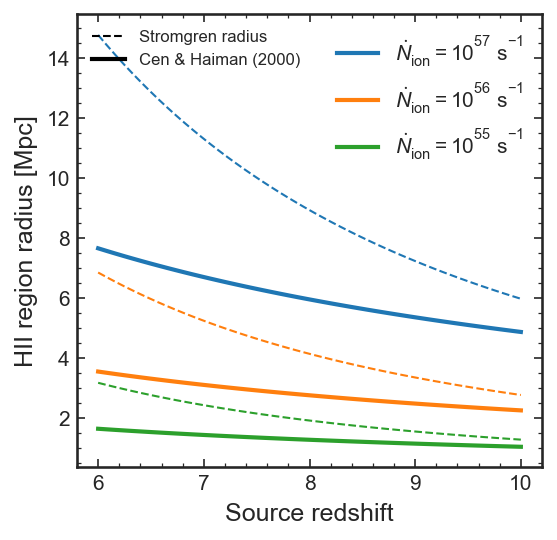

In [8]:
ztab = np.linspace(6., 10)

Ndot_ion_tab = [1.e57, 1.e56, 1.e55]

for Ndot_ion in Ndot_ion_tab:
    
    ln = plt.plot(ztab, R_bubble_Stromgren(ztab, Ndot_ion=Ndot_ion/u.s),
                 ls='dashed', lw=1)  
    
    plt.plot(ztab, R_bubble_CenHaiman2000(ztab, Ndot_ion=Ndot_ion/u.s, 
                                          t_source=1.e8*u.yr),
             c=ln[0].get_color(),
             label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion))


stromgren_line = mlines.Line2D([], [], color='k', lw=1, ls='dashed', label='Stromgren radius')
CenHaiman_line = mlines.Line2D([], [], color='k', lw=2, label='Cen & Haiman (2000)')

leg = plt.legend(handles=[stromgren_line, CenHaiman_line], loc='upper left', fontsize=8)
plt.gca().add_artist(leg)

plt.legend()

plt.xlabel('Source redshift')
plt.ylabel('HII region radius [Mpc]')

plt.savefig('../figs/R_HII_compare.pdf')

#### Change age

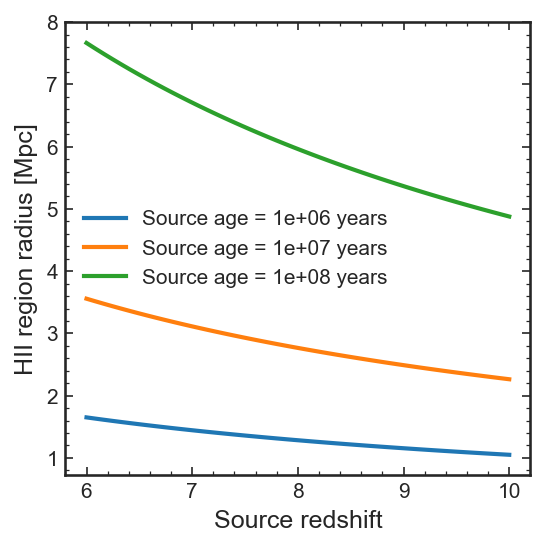

In [9]:
ztab = np.linspace(6., 10)

age_tab = np.logspace(-1, 1, 3)*1e7*u.year

for age in age_tab:
    
    plt.plot(ztab, R_bubble_CenHaiman2000(ztab, Ndot_ion=1e57/u.s, 
                                          t_source=age),
             label='Source age = %.0e years' % age.value)

plt.legend()

plt.xlabel('Source redshift')
plt.ylabel('HII region radius [Mpc]')

plt.savefig('../figs/R_HII_age.pdf')

### Ionized fraction

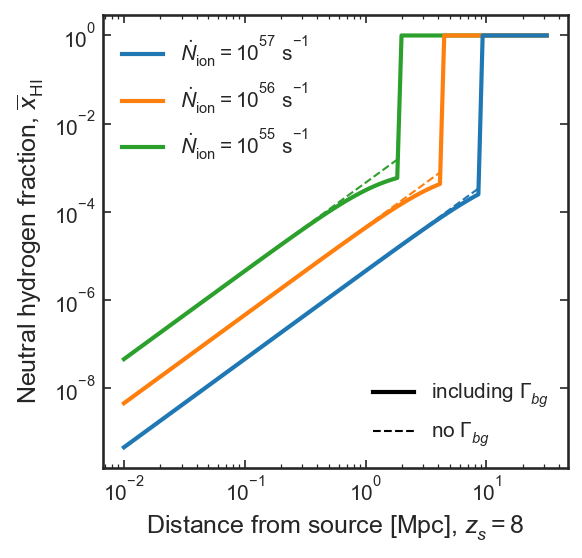

In [10]:
Rtab = np.logspace(-2, 1.5, 100)*u.Mpc
eV_tab = np.logspace(np.log10(13.6), 4)*u.eV
nu = (eV_tab/const.h).to(u.Hz)
 
z_s = 8.

fesc_tab = [1, 0.1, 0.01]
for fesc in fesc_tab:
    
    Ndot_ion = bubbles.Ndot_ion_from_Lnu(nu, fesc=fesc/2., qso=True)
    
    R_HII = R_bubble_Stromgren(z_s, Ndot_ion=Ndot_ion)
    
    # No background
    xHI_radial = xHI_R(r=Rtab, z_s=z_s, fesc=fesc/2., J_bg=False)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ln = plt.loglog(Rtab, xHI_radial, zorder=fesc, lw=1, ls='dashed')

    # With background
    xHI_radial = xHI_R(r=Rtab, z_s=z_s, fesc=fesc/2., J_bg=True)    
    xHI_radial[Rtab > R_HII] = 1.
    
    plt.loglog(Rtab, xHI_radial, zorder=fesc, lw=2, c=ln[0].get_color(),
               label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))

background_line   = mlines.Line2D([], [], color='k', lw=2, label='including $\Gamma_{bg}$')
nobackground_line = mlines.Line2D([], [], color='k', lw=1, ls='dashed', label='no $\Gamma_{bg}$')

leg = plt.legend(handles=[background_line, nobackground_line], loc='lower right')
plt.gca().add_artist(leg)

plt.legend()

plt.xlabel('Distance from source [Mpc], $z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $\overline{x}_\mathrm{HI}$')

plt.savefig('../figs/x_HI_withbg_zs=%.0f.pdf' % z_s)

#### As a function of spectral index

1.9935457956050737e+56 1 / s 1.993545795605074e+56 1 / s
1.993545795605074e+56 1 / s 1.993545795605074e+56 1 / s
1.993545795605074e+56 1 / s 1.993545795605074e+56 1 / s


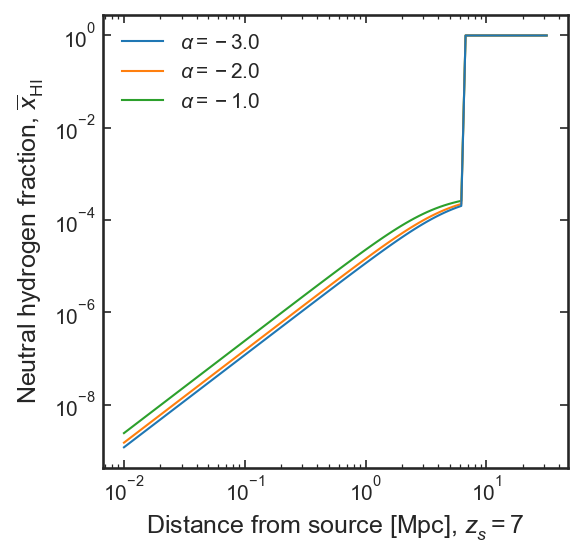

In [11]:
Rtab = np.logspace(-2, 1.5, 100)*u.Mpc
eV_tab = np.logspace(np.log10(13.6), 4)*u.eV
nu = (eV_tab/const.h).to(u.Hz)

fesc_scale = 0.1
Ndot_ion_18 = bubbles.ionizing_sources.Ndot_ion_from_Lnu(nu, fesc=fesc_scale, qso=True, alpha=-1.8)
z_s = 7.

alpha_tab = [-3, -2, -1.]
for alpha in alpha_tab:
    
    Ndot_ion = bubbles.ionizing_sources.Ndot_ion_from_Lnu(nu, fesc=fesc_scale, qso=True, alpha=alpha)

    fesc = fesc_scale * Ndot_ion_18/Ndot_ion
    Ndot_ion = bubbles.ionizing_sources.Ndot_ion_from_Lnu(nu, fesc=fesc, qso=True, alpha=alpha)
    print(Ndot_ion, Ndot_ion_18)

        
    R_HII = R_bubble_Stromgren(z_s, Ndot_ion=Ndot_ion)
    
    # No background
    xHI_radial = xHI_R(r=Rtab, z_s=z_s, fesc=fesc, J_bg=True, alpha=alpha)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ln = plt.loglog(Rtab, xHI_radial, zorder=fesc, lw=1,
                   label=r'$\alpha = %.1f$' % alpha)

plt.legend()

plt.xlabel('Distance from source [Mpc], $z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $\overline{x}_\mathrm{HI}$')

plt.savefig('../figs/x_HI_spectralindex.pdf')

## Ionization front ODE

$$ \frac{dR^3}{dz} + \frac{C n_H \alpha_B - 3 H(z)}{(1+z)H(z)} R^3 = \frac{3 \dot{N}_{ion}}{4\pi n_H (1+z)H(z)}$$

$\alpha_B = 2.59\times^{-13}$ cm^3/s (Draine p. 138, table 14.1)


In [421]:
def ionization_front_ionizations(z, Ndot_ion=1.e57/u.s):
    return (0.75 * Ndot_ion / (np.pi * n_H(z))).to(u.Mpc**3./u.s)

def ionization_front_recombinations(z, R=1.*u.Mpc, C=3, a_B=2.59e-13*u.cm**3./u.s):
    return (-a_B * C * n_H(z) * R**3.).to(u.Mpc**3./u.s)

def ionization_front_Hubble(z, R=1.*u.Mpc):
    return (3* Planck15.H(z) * R**3.).to(u.Mpc**3./u.s)

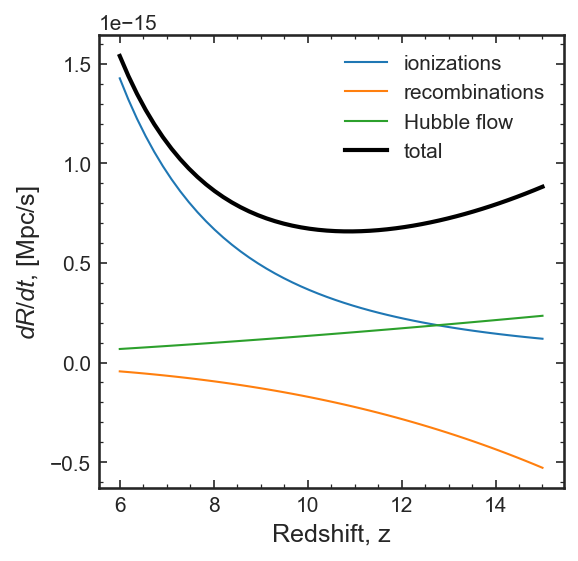

In [458]:
ztab = np.linspace(6, 15.)

horizon = (const.c/Planck15.H(z=ztab)).to(u.Mpc)
# print(horizon)

R = 1.*u.Mpc
Ndot_ion = 1.e55/u.s

dRdt_ion = ionization_front_ionizations(ztab, Ndot_ion=Ndot_ion)
dRdt_rec = ionization_front_recombinations(ztab, R=R)
dRdt_Hub = ionization_front_Hubble(ztab, R=R)

plt.plot(ztab, dRdt_ion, lw=1, label='ionizations')
plt.plot(ztab, dRdt_rec, lw=1, label='recombinations')
plt.plot(ztab, dRdt_Hub, lw=1, label='Hubble flow')

plt.plot(ztab, dRdt_ion - dRdt_rec + dRdt_Hub, c='k', label='total')

plt.xlabel('Redshift, z')
plt.ylabel('$dR/dt$, [Mpc/s]')

plt.legend()

In [117]:
def integrating_factor(z, C=3., a_B=2.59e-13*u.cm**3./u.s):
    
    def integrand(z):
        return ((C * n_H(z) * a_B - 3*Planck15.H(z))/(1. + z)/Planck15.H(z)).to(u.cm/u.cm)

    if z.size > 1:
        IF = np.zeros(len(z))
        for i, z_i in enumerate(z):
            uptoz = np.linspace(0., z_i, 100)
            IF[i] = np.exp(-np.trapz(integrand(uptoz), uptoz))
                           
    else:
        uptoz = np.linspace(0., z, 100)
        IF = np.exp(-np.trapz(integrand(uptoz), uptoz))
        
    return IF
        
def Q(z, Ndot=1e57/u.s):
    return (3.*Ndot/4./np.pi/n_H(z)/(1.+z)/Planck15.H(z)).to(u.Mpc**3)

def R_stromgren(z, Ndot=1e57/u.s, a_B=2.59e-13*u.cm**3./u.s):
    return ((3. * Ndot/4./np.pi/a_B/n_H(z)**2.)**(1./3.)).to(u.Mpc)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 581
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([100.        ,  98.08163265,  96.16326531,  94.24489796,
        92.32653061,  90.40816327,  88.48979592,  86.57142857,
        84.65306122,  82.73469388,  80.81632653,  78.89795918,
        76.97959184,  75.06122449,  73.14285714,  71.2244898 ,
        69.30612245,  67.3877551 ,  65.46938776,  63.55102041,
        61.63265306,  59.71428571,  57.79591837,  55.87755102,
        53.95918367,  52.04081633,  50.12244898,  48.20408163,
        46.28571429,  44.36734694,  42.44897959,  40.53061224,
        38.6122449 ,  36.69387755,  34.7755102 ,  32.85714286,
        30.93877551,  29.02040816,  27.10204082,  25.18367347,
        23.26530612,  21.34693878,  19.42857143,  17.51020408,
        15.59183673,  13.67346939,  11.75510204,   9.83673469,
         7.91836735,   6.        ])
 t_events: None
        y: ar

/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':


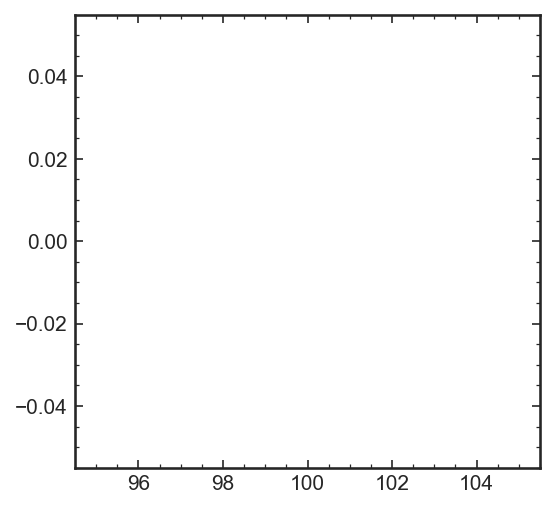

In [133]:
ztab = np.linspace(0., 1000)

def dR3dz(z, R3, C=3., a_B=2.59e-13*u.cm**3./u.s, Ndot=1e57/u.s):
    dR3_dt = 3.*Planck15.H(z)*R3*u.Mpc**3. + 3.*Ndot/4./np.pi/n_H(z) - C*n_H(z)*a_B*R3*u.Mpc**3.
    return (dR3_dt/(1.+z)/Planck15.H(z)).to(u.Mpc**3.).value

ztab = np.linspace(6., 100.)
R3 = integrate.solve_ivp(dR3dz,
                        t_span=(ztab.max(), ztab.min()), y0=[0.],
                        t_eval=np.linspace(ztab.max(), ztab.min(), 50),
                        method="RK23")

print(R3)
plt.plot(R3['t'], (R3['y'].T)**(1./3.))

# plt.plot(ztab, dR3dz(ztab, 10**3.))

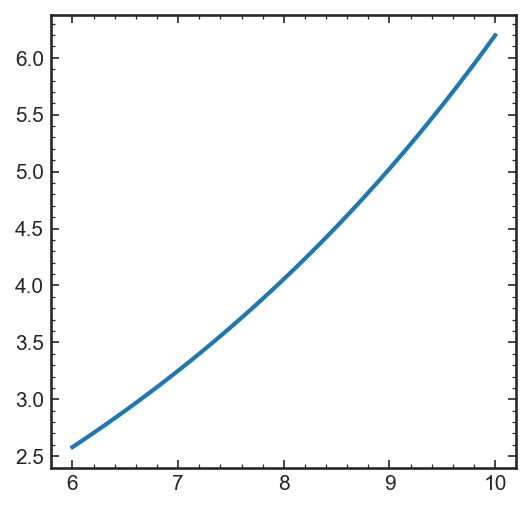

In [122]:
ztab = np.linspace(6., 10.)

R = np.zeros_like(ztab)
for zz, z in enumerate(ztab):
    z_i_tab = np.linspace(0., z)
    R3 = np.trapz(integrating_factor(z=z_i_tab)*Q(z_i_tab), z_i_tab)/integrating_factor(z=z) 
    R[zz] = R3.value**(1./3.)
    
plt.plot(ztab, R/R_stromgren(ztab))
# plt.plot(ztab, R_stromgren(ztab))

# Optical depth

$$ \tau(\lambda_{obs, z_s}) = \int_{z_0}^{z_s} \, dz \; c \frac{dt}{dz} n_H(z) \sigma_\alpha(\lambda_{obs}/(1+z)) $$

Neutral hydrogen density depends on HI fraction, calculate this inside the HII regions:

$$ n_H(z) = n_{H,0}(z) x_{HI}$$

In [12]:
def optical_depth(wave_em, T, z_min, z_max, z_s=7.,
                  inside_HII=True, C_HII=3., Ndot_ion=1.e57/u.s):
    """
    Lya optical depth as a function of wavelength 
    using definition of optical depth and Lya cross-section
    """
    
    # Redshift array
    ztab_ends = np.array([z_min, z_max])
    
    # Observed wavelength
    wave_obs = wave_em * (1. + z_s)
        
    # Range of redshifted wavelength and x
    wave_z_ends = wave_obs[:,None]/(1+ztab_ends)
    x_z_ends    = bubbles.Lya_wave_to_x(wave_z_ends, T=T)

    tau = np.zeros(len(wave_obs))
    for ww, w_obs in enumerate(wave_obs):
                
        # Make xtab 
        if (x_z_ends[ww] < 0).all():
            xtab = -np.logspace(np.log10(-x_z_ends[ww].min()),np.log10(-x_z_ends[ww].max()),100)
            xtab = np.sort(xtab)
        elif (x_z_ends[ww] > 0).all():
            xtab = np.logspace(np.log10(x_z_ends[ww].min()),np.log10(x_z_ends[ww].max()),100)
            xtab = np.sort(xtab)
        else:       
            xtab_neg = -np.logspace(-1,np.log10(-x_z_ends[ww].min()),50)
            xtab_pos = np.logspace(-1,np.log10(x_z_ends[ww].max()),50)
            xtab     = np.sort(np.concatenate((xtab_neg, xtab_pos)))
        
        # Get wave_redshift
        wave_redshift = bubbles.Lya_x_to_wave(xtab, T=T)

        # Get z tab
        ztab = w_obs/wave_redshift - 1.

        # Residual neutral fraction
        if inside_HII:
            r = bubbles.comoving_distance_from_source_Mpc(ztab, z_s)
            xHI = xHI_R(r, z_s, fesc=0.5*Ndot_ion/(1.e57/u.s), C=3.) # Only source flux
        else:
            xHI = 1.
            
        # Cross-section
        lya_cross = bubbles.Lya_crosssec(wave_redshift, T=T)
                           
        # Calculate optical depth
        prefac = (const.c * bubbles.dt_dz(ztab) * xHI * bubbles.n_H(ztab)).to(1./u.cm**2.)
        dtau   = prefac * lya_cross
    
        tau[ww] = np.trapz(dtau, ztab)
        
    return tau

In [13]:
def plot_tau(tau_tab, wave_em, R_ion, transmission=False, 
             ax=None, annotate=True):
    
    tau_HII, tau_IGM, tau_total = tau_tab
    
    if transmission:
        tau_HII, tau_IGM, tau_total = np.exp(-tau_HII), np.exp(-tau_IGM), np.exp(-tau_total)
        ylabel = r'Ly$\alpha$ transmission, $e^{-\tau_{\mathrm{Ly}\alpha}}$'
    else:
        ylabel = r'Optical depth $\tau_{\mathrm{Ly}\alpha}$'
    
    # Make DV table
    DV_tab = bubbles.wave_to_DV(wave_em)

    if ax is None:
        fig, ax_wave = plt.subplots(1,1)
    else:
        ax_wave=ax

    ax_wave.plot(wave_em, tau_HII, lw=1, ls='dashed', label='inside HII region')
    ax_wave.plot(wave_em, tau_IGM, lw=1, ls='dotted', label='IGM')
    ax_wave.plot(wave_em, tau_total, label='total')

    # DV plot
    ax_DV = ax_wave.twiny()
    ax_DV.semilogy(DV_tab, tau_total, label='total', lw=0)

    ax_wave.legend(loc='upper right')#, frameon=True)
    
    if transmission:
        plt.yscale('linear')
        ax_wave.set_ylim(-0.1, 1.1)
    else:
        plt.yscale('log')
        ax_wave.set_ylim(1e-6, 1.2e6)
        
    ax_DV.set_xlim(-1000, 1000)
    ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

    if annotate:
        ax_wave.annotate('$R_{HII}=%.1f$ Mpc' % R_ion.value, xy=(0.98, 0.05), xycoords='axes fraction', ha='right')
    
    ax_wave.set_ylabel(ylabel)
    ax_wave.set_xlabel('Wavelength [A]')
    ax_DV.set_xlabel('Velocity offset [km/s]')
    
    plt.tight_layout()
    
    return

### Damping wing approximations

In [375]:
f_a = 0.4164 # Oscillator strength from Draine sec. 9.7
squared_electron_charge_cgs = (const.e.esu**2.).to(u.cm**3. * u.g/ u.s**2.)

def optical_depth_damping_ME98(z, x_HI, z_s, z_HII, z_end):
    """
    Miralda-Escude 1998 approximation for the damping wing
    """
    
    prefac = 6.43e-9 * wave_Lya * x_HI * (np.pi * squared_electron_charge_cgs * f_a / const.m_e / const.c) * (n_H(z) / Planck15.H(z))
    
    tau = prefac.to(u.cm/u.cm) * (I((1.+z_HII)/(1.+z)) - I((1.+z_end)/(1.+z)))
    
    return tau

def optical_depth_damping_DW10(z_min, z_s=7.,
                               x_HI=1., R_HII=1*u.Mpc):
    """
    Eqn 104 in Dijkstra lecture notes
    """
    
    ztab = np.linspace(z_min, z_s, 1000)
    
    deltav = ((z_s - ztab)/(1 + z_s) * const.c).to(u.km/u.s)    
    deltav_HII = (deltav + Planck15.H(z_s)*R_HII/(1+z_s)).to(u.km/u.s)
    
    tau = 2.3 * x_HI * (600 * u.km/u.s / deltav_HII) * ((1. + z_s)/10.)**1.5
    
    return deltav, tau

    
def I(x):
    return x**4.5/(1.- x) + 9./7.*x**3.5 + 9./5.*x**2.5 + 3*x**1.5 + 9*x**0.5 - np.log(np.abs(((1+x**0.5)/(1-x**0.5))))

## Simple case with Stromgren sphere

In [380]:
wave_em = np.linspace(1210, 1220., 1000) * u.Angstrom

z_s   = 7.
z_min = 6.

Ndot_ion = 1.e57/u.s

R_ion = R_bubble_CenHaiman2000(z_s, Ndot_ion=Ndot_ion)
z_ion = z_bubble(R_ion, z_s=z_s)

print(R_ion, z_ion)

# inside bubble
tau_HII = optical_depth(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                        inside_HII=True, T=1.e4*u.K, Ndot_ion=Ndot_ion)

# in IGM
tau_IGM = optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                        inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

3.1130177630958102 Mpc 6.991125391413053


Text(0.5, 0, 'Velocity offset [km/s]')

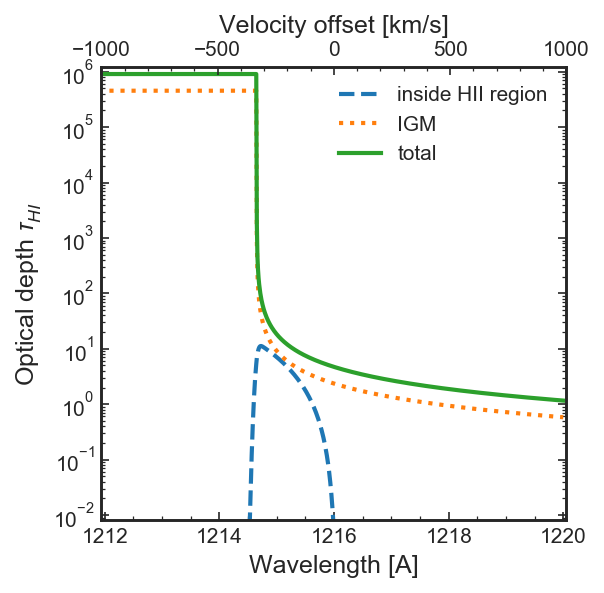

In [381]:
DV_tab = wave_to_DV(wave_em)

fig, ax_wave = plt.subplots(1,1)

ax_wave.semilogy(wave_em, tau_HII, ls='dashed', label='inside HII region')
ax_wave.semilogy(wave_em, tau_IGM, ls='dotted', label='IGM')

tau_total = tau_IGM + tau_IGM

ax_wave.semilogy(wave_em, tau_total, label='total')

ax_DV = ax_wave.twiny()
ax_DV.semilogy(DV_tab, tau_total, label='total', lw=0)

ax_wave.legend()
ax_wave.set_ylim(0.8e-2, 1.2e6)
ax_DV.set_xlim(-1000, 1000)
ax_wave.set_xlim(DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Optical depth $\tau_{HI}$')
ax_wave.set_xlabel('Wavelength [A]')
ax_DV.set_xlabel('Velocity offset [km/s]')

## Cen & Haiman

In [145]:
Ndot_ion = 2.e55/u.s 

z_s = 7.

R_ion = R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=1e8*u.year)
z_ion = bubbles.z_at_comoving_distance(R_ion, z_1=z_s)
z_min = 6.

print(R_ion, z_ion)

wave_em = np.linspace(1210, 1220., 1000) * u.Angstrom

# inside bubble
tau_HII = optical_depth(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                        inside_HII=True, T=1.e4*u.K, Ndot_ion=Ndot_ion)

# in IGM
tau_IGM = optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                        inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

tau_total = tau_IGM + tau_HII

1.8205038317327773 Mpc 6.9948100974144145


/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


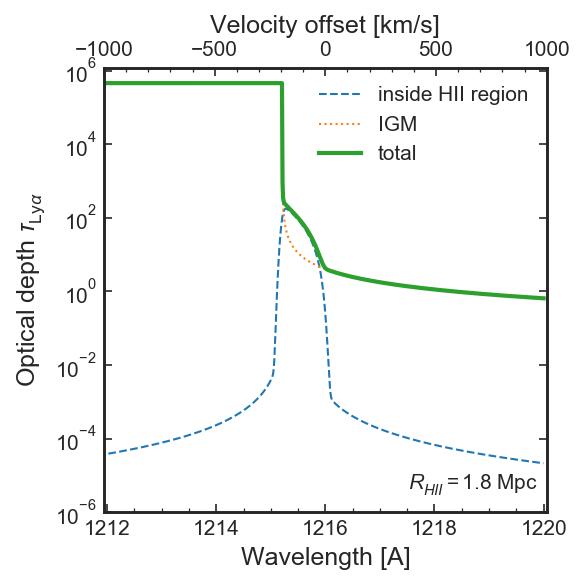

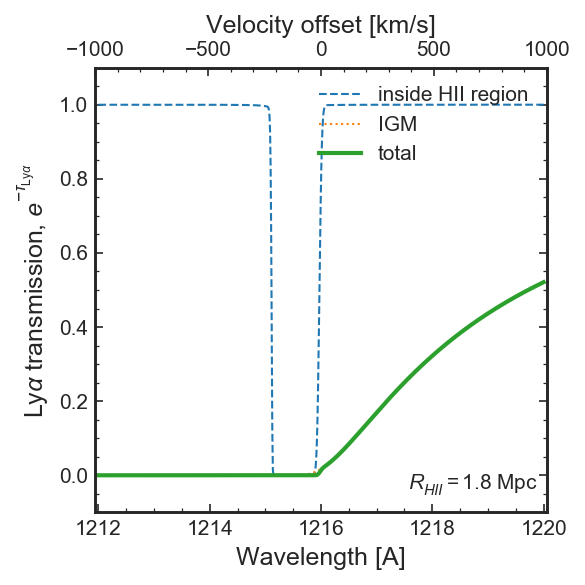

In [149]:
tau_tab = tau_HII, tau_IGM, tau_total

plot_tau_all(tau_tab, wave_em, R_ion, transmission=False)
plot_tau_all(tau_tab, wave_em, R_ion, transmission=True)

### Make animation

In [15]:
wave_em = np.linspace(1210, 1220., 1000) * u.Angstrom

def make_tau(Ndot_ion, source_age, z_s=7., z_min=6.):
    
    R_ion = R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=source_age)
    z_ion = bubbles.z_at_comoving_distance(R_ion, z_1=z_s)

    # inside bubble
    tau_HII = optical_depth(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                            inside_HII=True, T=1.e4*u.K, Ndot_ion=Ndot_ion)

    # in IGM
    tau_IGM = optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                            inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

    tau_total = tau_IGM + tau_HII
    
    tau_tab = tau_HII, tau_IGM, tau_total
    return tau_tab, R_ion

#### Update Nion

/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


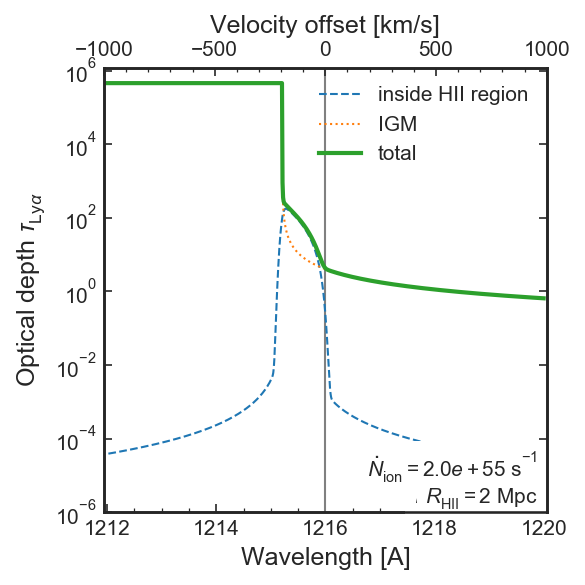

In [576]:
transmission = True
Ndot_ion_tab = np.logspace(-2, 1, 10)*2e57/u.s

fig, ax_wave = plt.subplots(1,1)

ax_wave.axvline(1216., lw=1, c='0.5')

def update_tau_Nion(i):
    # Get new tau and R_ion
    tau_tab, R_ion = make_tau(Ndot_ion=Ndot_ion_tab[i], source_age=1e8*u.year, z_s=7., z_min=6.)
    
    # Plot
    for tt, t in enumerate(tau_tab):
        if transmission:
            ax_wave.lines[tt+1].set_ydata(np.exp(-t))
        else:
            ax_wave.lines[tt+1].set_ydata(t)
            
    # Annotate
    ax_wave.annotate(r'$\dot{N}_\mathrm{ion}=%.1e$ s$^{-1}$' % Ndot_ion_tab[i].value, xy=(0.98, 0.08), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    ax_wave.annotate(r'$R_\mathrm{HII}=%.0f$ Mpc' % np.round(R_ion.value, 0), xy=(0.98, 0.02), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    
# First one
tau_tab, R_ion = make_tau(Ndot_ion=Ndot_ion_tab[0], source_age=1e7*u.year, z_s=7., z_min=6.)
plot_tau(tau_tab, wave_em, R_ion, transmission=transmission, ax=ax_wave, annotate=False)

# Animate
anim_tau = FuncAnimation(fig, update_tau, frames=np.arange(len(Ndot_ion_tab)), interval=600) # interval in ms

if transmission:
    plotname = '../figs/transmission_animate_Nion.gif'
else:
    plotname = '../figs/optdepth_animate_Nion.gif'

anim_tau.save(plotname, dpi=150, writer='imagemagick')

#### Update age

[1.00000000e+06 1.66810054e+06 2.78255940e+06 4.64158883e+06
 7.74263683e+06 1.29154967e+07 2.15443469e+07 3.59381366e+07
 5.99484250e+07 1.00000000e+08] yr


/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


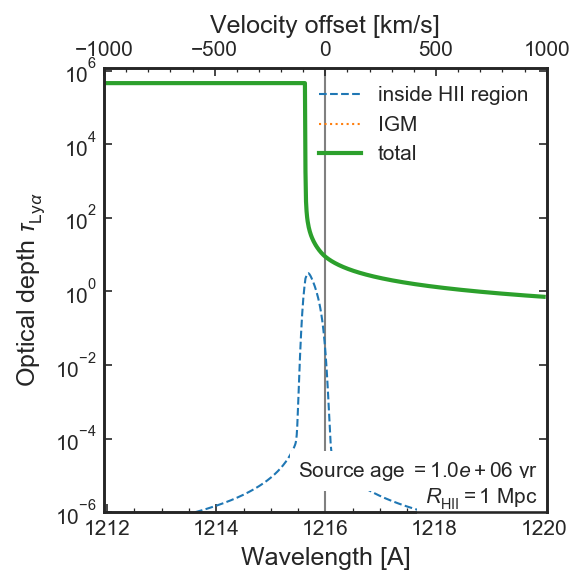

In [167]:
transmission = False
source_age_tab = np.logspace(-2, 0, 10)*1e8*u.year
print(source_age_tab)

fig, ax_wave = plt.subplots(1,1)

ax_wave.axvline(1216., lw=1, c='0.5')

def update_tau_age(i):
    # Get new tau and R_ion
    tau_tab, R_ion = make_tau(Ndot_ion=2e56/u.s, source_age=source_age_tab[i], z_s=7., z_min=6.)
    
    # Plot
    for tt, t in enumerate(tau_tab):
        if transmission:
            ax_wave.lines[tt+1].set_ydata(np.exp(-t))
        else:
            ax_wave.lines[tt+1].set_ydata(t)
            
    # Annotate
    ax_wave.annotate(r'Source age $=%.1e$ yr' % source_age_tab[i].value, xy=(0.98, 0.08), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    ax_wave.annotate(r'$R_\mathrm{HII}=%.0f$ Mpc' % np.round(R_ion.value, 0), xy=(0.98, 0.02), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    
# First one
tau_tab, R_ion = make_tau(Ndot_ion=2e56/u.s, source_age=source_age_tab[0], z_s=7., z_min=6.)
plot_tau_all(tau_tab, wave_em, R_ion, transmission=transmission, ax=ax_wave, annotate=False)

# Animate
anim_tau = FuncAnimation(fig, update_tau_age, frames=np.arange(len(source_age_tab)), interval=600) # interval in ms

if transmission:
    plotname = '../figs/transmission_animate_age.gif'
else:
    plotname = '../figs/optdepth_animate_age.gif'

anim_tau.save(plotname, dpi=150, writer='imagemagick')

# Optical depth on a grid of Nion

## Make a grid

In [210]:
z_s   = 7.
z_min = 6.
source_age = 1e7*u.year

Ndot_ion_tab = np.logspace(-3, 1, 50)*2e57/u.s
  
tau_tot_tab = []
R_ion_tab   = []
for Ndot_ion in Ndot_ion_tab:
    tau_tab, R_ion = make_tau(Ndot_ion=Ndot_ion, source_age=source_age, z_s=z_s, z_min=z_min)
    print(Ndot_ion, R_ion)
    tau_HII, tau_IGM, tau_total = tau_tab

    R_ion_tab.append(R_ion.value)
    tau_tot_tab.append(tau_total)
    
tau_tot_tab = np.array(tau_tot_tab)
R_ion_tab   = np.array(R_ion_tab)

/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


2e+54 1 / s 0.39221566084210635 Mpc
2.4135852812786578e+54 1 / s 0.41757627424212923 Mpc
2.912696955002489e+54 1 / s 0.4445767015920707 Mpc
3.515021249709583e+54 1 / s 0.4733229730477448 Mpc
4.241901775840381e+54 1 / s 0.5039279746609915 Mpc
5.119095845399072e+54 1 / s 0.5365118916810178 Mpc
6.177687192954963e+54 1 / s 0.5712026805195458 Mpc
7.455187440629877e+54 1 / s 0.6081365712331666 Mpc
8.996865337938889e+54 1 / s 0.6474586024961367 Mpc
1.0857350878647719e+55 1 / s 0.6893231911644454 Mpc
1.3102571137191018e+55 1 / s 0.7338947386678204 Mpc
1.5812086421815404e+55 1 / s 0.7813482766109624 Mpc
1.908190952699989e+55 1 / s 0.83187015411927 Mpc
2.302790798652894e+55 1 / s 0.8856587696282489 Mpc
2.7789909887462746e+55 1 / s 0.9429253499903317 Mpc
3.3536658736220156e+55 1 / s 1.0038947799586388 Mpc
4.047179295450313e+55 1 / s 1.0688064853050534 Mpc
4.884106189097302e+55 1 / s 1.1379153730405958 Mpc
5.89410340510362e+55 1 / s 1.2114928324303236 Mpc
7.112960612446258e+55 1 / s 1.289827800733

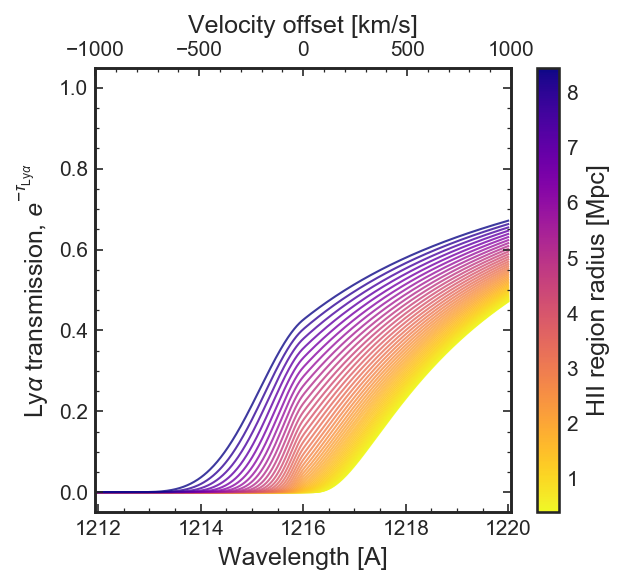

In [236]:
# Plot
norm = mpl.colors.Normalize(vmin=np.min(R_ion_tab), vmax=np.max(R_ion_tab))

# choose a colormap
c_m = cubehelix3_16.get_mpl_colormap()
c_m = mpl.cm.plasma_r


# create ScalarMappable and initialize a data structure
s_m = mpl.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

DV_tab = bubbles.wave_to_DV(wave_em)

fig, ax_wave = plt.subplots(1,1, figsize=(4.3,4))
ax_DV = ax_wave.twiny()
    
for i, R_ion in enumerate(R_ion_tab):
#     if i % 4 == 0:
        ax_wave.plot(wave_em, np.exp(-tau_tot_tab[i]), c=s_m.to_rgba(R_ion), lw=1, alpha=0.8, zorder=0)
        ax_DV.plot(DV_tab, np.exp(-tau_tot_tab[i]), lw=0)

plt.colorbar(s_m, label='HII region radius [Mpc]')

plt.yscale('linear')
ax_wave.set_ylim(-0.05, 1.05)
ax_DV.set_xlim(-1000, 1000)
ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Ly$\alpha$ transmission, $e^{-\tau_{\mathrm{Ly}\alpha}}$')
ax_wave.set_xlabel('Wavelength [A]')
ax_DV.set_xlabel('Velocity offset [km/s]')

plt.tight_layout()
plt.savefig('../figs/transmission_R_HII.pdf')

## Video of grid

In [16]:
z_s   = 7.
z_min = 6.
source_age = 1e7*u.year

Ndot_ion_tab = np.logspace(-3, 1, 50)*2e57/u.s
  
tau_tot_tab = []
R_ion_tab   = []
for Ndot_ion in Ndot_ion_tab:
    tau_tab, R_ion = make_tau(Ndot_ion=Ndot_ion, source_age=source_age, z_s=z_s, z_min=z_min)
    print(Ndot_ion, R_ion)
    tau_HII, tau_IGM, tau_total = tau_tab

    R_ion_tab.append(R_ion.value)
    tau_tot_tab.append(tau_total)
    
tau_tot_tab = np.array(tau_tot_tab)
R_ion_tab   = np.array(R_ion_tab)

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


2e+54 1 / s 0.39221566084210635 Mpc
2.4135852812786578e+54 1 / s 0.41757627424212923 Mpc
2.912696955002489e+54 1 / s 0.4445767015920707 Mpc
3.515021249709583e+54 1 / s 0.4733229730477448 Mpc
4.241901775840381e+54 1 / s 0.5039279746609915 Mpc
5.119095845399072e+54 1 / s 0.5365118916810178 Mpc
6.177687192954963e+54 1 / s 0.5712026805195458 Mpc
7.455187440629877e+54 1 / s 0.6081365712331666 Mpc
8.996865337938889e+54 1 / s 0.6474586024961367 Mpc
1.0857350878647719e+55 1 / s 0.6893231911644454 Mpc
1.3102571137191018e+55 1 / s 0.7338947386678204 Mpc
1.5812086421815404e+55 1 / s 0.7813482766109624 Mpc
1.908190952699989e+55 1 / s 0.83187015411927 Mpc
2.302790798652894e+55 1 / s 0.8856587696282489 Mpc
2.7789909887462746e+55 1 / s 0.9429253499903317 Mpc
3.3536658736220156e+55 1 / s 1.0038947799586388 Mpc
4.047179295450313e+55 1 / s 1.0688064853050534 Mpc
4.884106189097302e+55 1 / s 1.1379153730405958 Mpc
5.89410340510362e+55 1 / s 1.2114928324303236 Mpc
7.112960612446256e+55 1 / s 1.289827800733

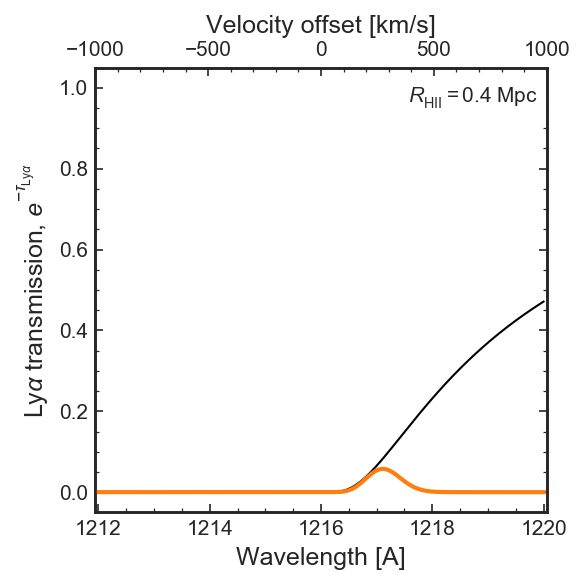

In [53]:
DV_tab = bubbles.wave_to_DV(wave_em)

fig, ax_wave = plt.subplots(1,1, figsize=(4,4))
ax_DV = ax_wave.twiny()

plt.yscale('linear')
ax_wave.set_ylim(-0.05, 1.05)
ax_DV.set_xlim(-1000, 1000)
ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Ly$\alpha$ transmission, $e^{-\tau_{\mathrm{Ly}\alpha}}$')
ax_wave.set_xlabel('Wavelength [A]')
ax_DV.set_xlabel('Velocity offset [km/s]')

def update_tau_R(i):
    # Get new tau and R_ion    
    # Plot
    ax_wave.lines[0].set_ydata(np.exp(-tau_tot_tab[i]))
    ax_DV.lines[1].set_ydata(np.exp(-tau_tot_tab[i])*400*lines[10])
            
    # Annotate
    ax_wave.annotate(r'$R_\mathrm{HII}=%.1f$ Mpc' % np.round(R_ion_tab[i], 1), xy=(0.98, 0.92), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    
# First one
ax_wave.plot(wave_em, np.exp(-tau_tot_tab[0]), lw=1, c='k')
ax_DV.plot(DV_tab, np.exp(-tau_tot_tab[0]), lw=0)
ax_DV.plot(velocity, np.exp(-tau_tot_tab[0])*400*lines[10], zorder=0)

# Animate
anim_tau = FuncAnimation(fig, update_tau_R, frames=np.arange(len(R_ion_tab)), 
                         interval=200) # interval in ms

plotname = '../figs/transmission_animate_Rion.gif'

plt.tight_layout()

anim_tau.save(plotname, dpi=150, writer='imagemagick')

# Add fake lines

In [27]:
def lineshape_doublepeak(v, vcenter):
    """
    Gaussian line shape
    
    :param v:        velocity offset from systemic
    :param vcenter:  center of gaussian in v

    :return: Gaussian lineshape as a function of v
    """
    fwhm  = vcenter
    sigma = fwhm/2.355
    
    if vcenter == 0:
        sigma = 10/2.355
        line = 0.3989422804014327 * np.exp(-0.5*((v + vcenter)/sigma)**2.) / sigma
    else:
        line_blue = 0.3989422804014327 * np.exp(-0.5*((v + vcenter)/sigma)**2.) / sigma
        line_red  = 0.3989422804014327 * np.exp(-0.5*((v - vcenter)/sigma)**2.) / sigma
        line  = line_blue + line_red

    # Truncate and normalise
    line /= np.trapz(line, v)
    return line

## Grid of lines

Text(0, 0.5, 'Normalized Lya flux')

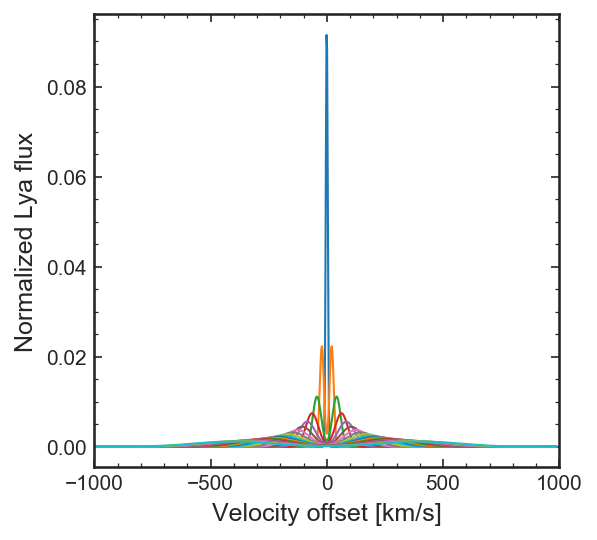

In [28]:
line_DV = np.linspace(-500., 500, 20)
line_DV = np.linspace(0., 400, 20)

velocity = bubbles.wave_to_DV(wave_em).value

# lines = np.array([reionizer.line_shape_gauss(v=velocity, vcenter=DV, fwhm=DV, vmin=-2000.) for DV in line_DV])
lines = np.array([lineshape_doublepeak(v=velocity, vcenter=DV) for DV in line_DV])

plt.plot(velocity, lines.T, lw=1)

plt.xlim(-1000, 1000)

plt.xlabel('Velocity offset [km/s]')
plt.ylabel('Normalized Lya flux')

## Multiply by transmission

Text(0, 0.5, 'Normalized Lya flux')

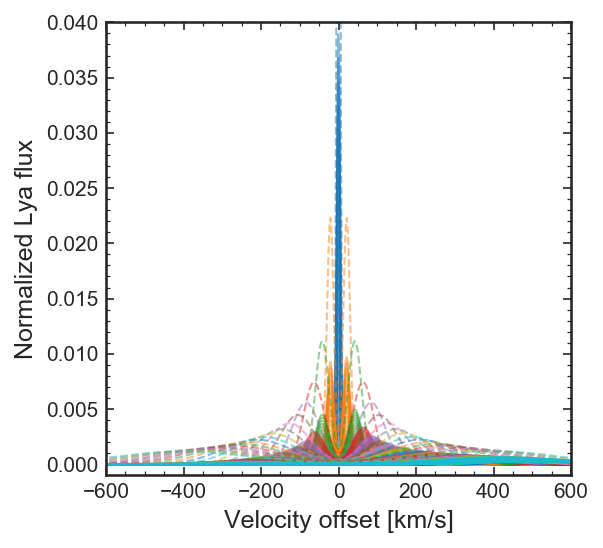

In [309]:
Tigm      = np.zeros((len(lines), len(tau_tot_tab)))
Tigm_blue = np.zeros((len(lines), len(tau_tot_tab)))
Tigm_red = np.zeros((len(lines), len(tau_tot_tab)))

for i, line in enumerate(lines):
    ln = plt.plot(velocity, line, lw=1, alpha=0.5, ls='dashed')
    
    trans_tot_tab = np.exp(-tau_tot_tab)
    plt.plot(velocity, (line*trans_tot_tab).T, c=ln[0].get_color(), lw=1, alpha=0.5)
    
    Tigm_blue[i] = 2*np.trapz(line[velocity < 0.]*trans_tot_tab.T[np.where(velocity < 0.)].T, velocity[velocity < 0.])
    Tigm_red[i]  = 2*np.trapz(line[velocity >= 0.]*trans_tot_tab.T[np.where(velocity >= 0.)].T, velocity[velocity >= 0.])
    Tigm[i]      = np.trapz(line*trans_tot_tab, velocity)
    
plt.xlim(-600, 600)
plt.ylim(-0.001, 0.04)
plt.xlabel('Velocity offset [km/s]')
plt.ylabel('Normalized Lya flux')

## What is minimum R_HII required to see a blue peak?

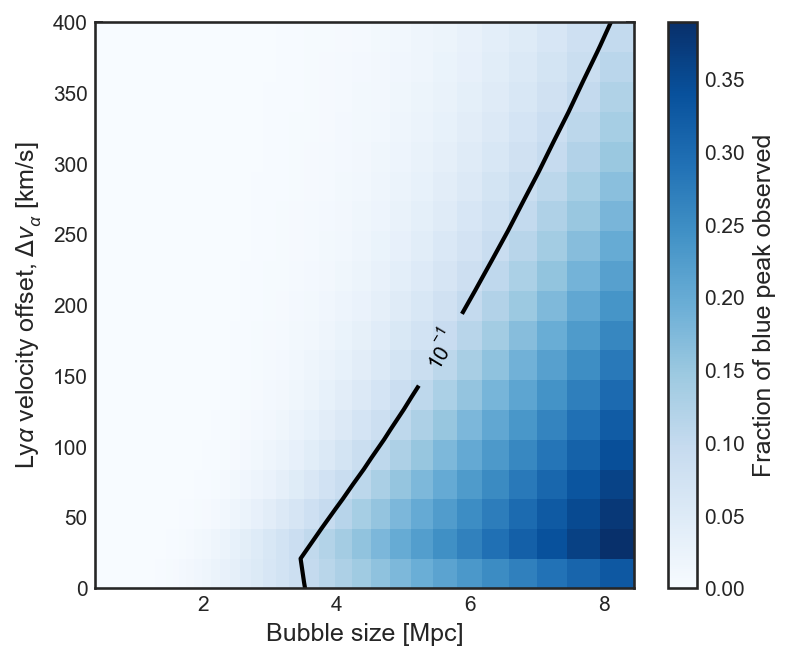

In [319]:
plt.figure(figsize=(5.8, 5))

im = plt.pcolormesh(R_ion_tab, line_DV, Tigm_blue, cmap='Blues')
plt.colorbar(im, label=r'Fraction of blue peak observed')

# Tigm_levels = [0.001, 0.01, 0.1]
# linestyles=['solid', 'dashed', 'dotted']
Tigm_levels = [0.1]
cs = plt.contour(R_ion_tab, line_DV, Tigm_blue, levels=Tigm_levels, 
                 colors='k')

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)

plt.xlabel('Bubble size [Mpc]')
plt.ylabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('transmission_bubblesize_deltav_bluepeak.pdf', bbox_inches='tight')

## What is minimum R_HII required to see red peak?

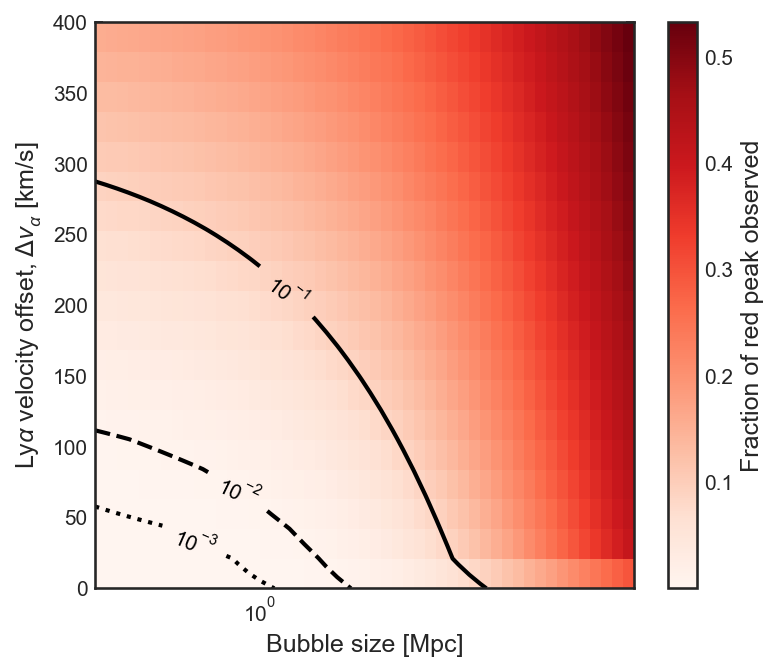

In [352]:
fig, ax = plt.subplots(1,1, figsize=(5.8, 5))

im = plt.pcolormesh(R_ion_tab, line_DV, Tigm_red, cmap='Reds')
ax.set_xscale('log')

Tigm_levels = [0.001, 0.01, 0.1]
linestyles=['dotted', 'dashed', 'solid']
cs = plt.contour(R_ion_tab, line_DV, Tigm_red, levels=Tigm_levels, 
                 colors='k', linestyles=linestyles)

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

# locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
# ax.xaxis.set_minor_locator(locmin)
# ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
# plt.minorticks_on()
# ax.Tick.zorder = 1000
plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)
plt.colorbar(im, label=r'Fraction of red peak observed')

ax.tick_params(zorder='')

plt.xlabel('Bubble size [Mpc]')
plt.ylabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('transmission_bubblesize_deltav_redpeak.pdf', bbox_inches='tight')

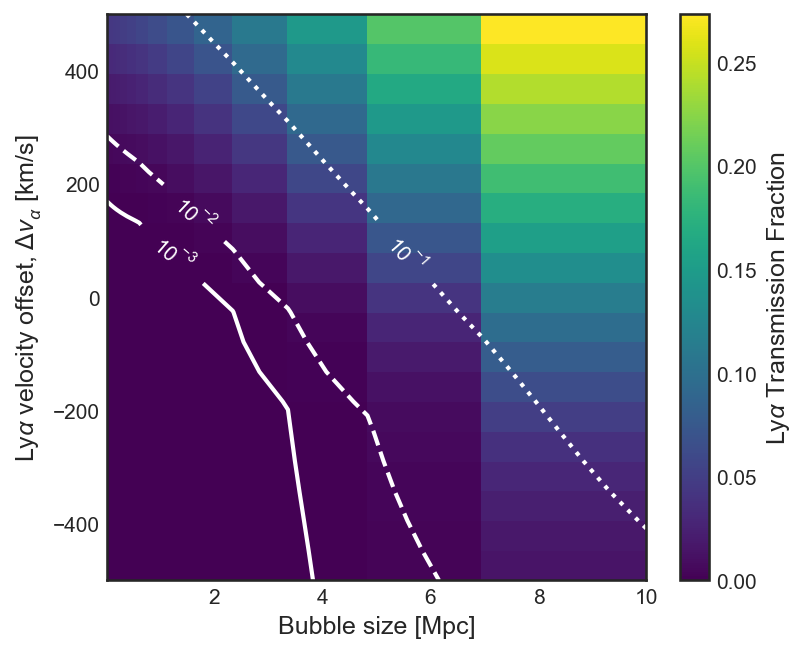

In [319]:
# reionizer.plot_image(Tigm, R_ion.value, line_DV,
#                      xlabel='Bubble size [Mpc]', 
#                      ylabel=r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]', 
#                      cmap='viridis', clabel=r'Ly$\alpha$ Transmission Fraction')

plt.figure(figsize=(5.8, 5))

im = plt.pcolormesh(R_ion.value, line_DV, Tigm, cmap='viridis')
plt.colorbar(im, label=r'Ly$\alpha$ Transmission Fraction')

Tigm_levels = [0.001, 0.01, 0.1]
cs = plt.contour(R_ion.value, line_DV, Tigm, levels=Tigm_levels, 
                 colors='w', linestyles=['solid', 'dashed', 'dotted'])

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

plt.clabel(cs, cs.levels, fmt=fmt, inline_spacing=20.)

plt.xlabel('Bubble size [Mpc]')
plt.ylabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('transmission_bubblesize_deltav.pdf', bbox_inches='tight')

Text(0, 0.5, 'Lya transmission')

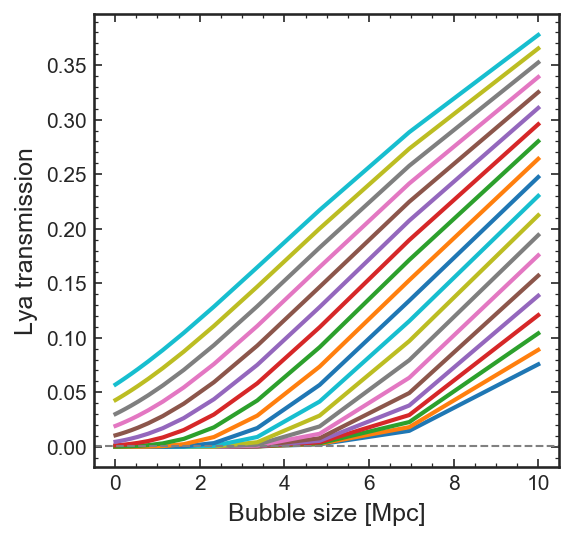

In [320]:
for i, line in enumerate(lines):
    plt.plot(R_ion, Tigm[i])
plt.axhline(1e-3, c='0.5', ls='dashed', lw=1)
plt.xlabel('Bubble size [Mpc]')
plt.ylabel('Lya transmission')

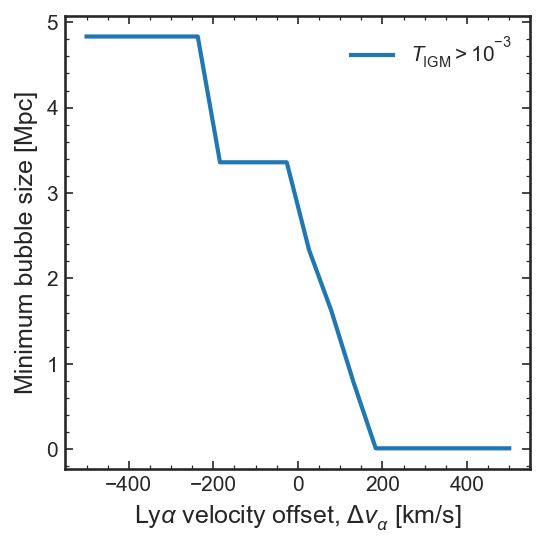

In [321]:
min_bubble_size = np.zeros(len(lines))
for i, line in enumerate(lines):
    min_bubble_size[i] = R_ion[np.where(Tigm[i] >= 1.e-3)[0][0]].value

plt.plot(line_DV, min_bubble_size, label=r'$T_\mathrm{IGM} > 10^{-3}$')

plt.legend()

plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')

plt.savefig('min_bubblesize_deltav.pdf', bbox_inches='tight')

# Ionizing background model Khaire & Srianand 2019

[Khaire & Srianand 2019](https://arxiv.org/abs/1801.09693) fiducial quasar SED $\alpha=-1.8$. Which was found to reproduce the measured He II Lyman-α effective optical depths as a function of z and the epoch of He II reionization

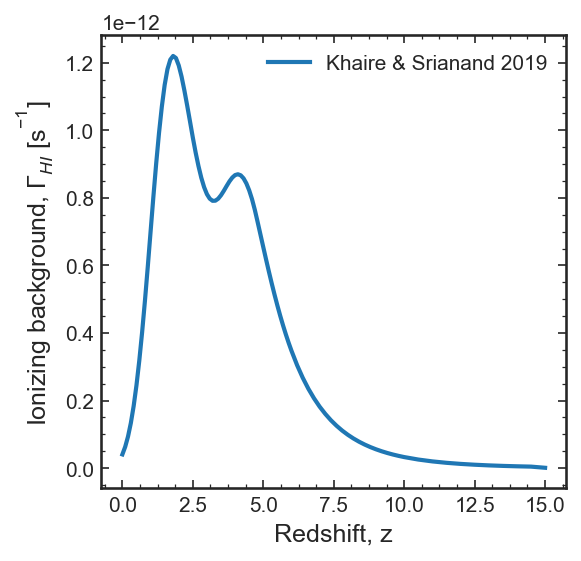

In [31]:
bubbles.ionizing_sources.plot_Gamma12_bg()